In [92]:
import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dropout,Dense,Conv2D,BatchNormalization,MaxPooling2D,Flatten
from keras.optimizers import SGD
from keras import initializers
from keras import regularizers

import sys
if '../input/train-model/' not in sys.path:
    sys.path.append('../input/train-model/')
#sys.path
#del sys
#sys.path.remove('../input/train-model/')
print(sys.path)
from my_utils import utils_paths
#del utils_paths

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle
import cv2
import os


['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/root/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/root/src/BigQuery_Helper', '../input/train-model/']


In [93]:
# 输入参数（jupter中用它https://blog.csdn.net/bagba/article/details/122087316）
try:
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("-d","--dataset",#required=True,
                    default="../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database",
                    help="path to input dataset of images")
    ap.add_argument("-m","--model",#required=True,
                    default="/kaggle/working/",
                    help="path to output trained model ")
    ap.add_argument("-l","-label-bin",#required=True,
                    default=114,
                    help="path to output label binarizer")
    ap.add_argument("-p","--plot",#required=True,
                    default="/kaggle/working/",
                    help="path to output accuracy/loss plot")
    args = vars(ap.parse_args())
except:
    args={}
    Paths=['../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/', #0
           '../input/chest-xray-pneumoniacovid19tuberculosis/train/', #1
           '../input/chest-xray-pneumoniacovid19tuberculosis/test/', #2
           '../input/preprocessed/output/output', #3
           '../input/preprocessed/extra/extra', #4
           '../input/preprocessed/extra/extra', #5
           '../input/segmentation/Segmentation/Segmentation',#6
           '../input/segmentation/extra- segmentation/extra', #7
           '../input/segmentation/extra- segmentation/extra',#8
           '../input/old-data-split/training', #9
           '../input/old-data-split/validation', #10
           '../input/old-data-split/testing' #11
          ]
    
    args["training_dataset"] = Paths[0]
    args["finetune_dataset"] = Paths[1]
    args["test_dataset"] = Paths[2]
    
    args["target_classes"] = [["Normal","Tuberculosis"], #0
                              ["NORMAL","TURBERCULOSIS"], #1
                              ["NORMAL","TURBERCULOSIS"], #2
                              ["processed_normal","processed_tb"], #3
                              ["train_normal","train_tb"], #4
                              ["test_normal","test_tb"], #5
                              ["normal_segmentation","tb_segmentation"], #6
                              ["Seg_train_normal","Seg_train_tb"], #7
                              ["Seg_test_normal","Seg_test_tb"], #8
                              ["Normal","Tuberculosis"], #9
                              ["Normal","Tuberculosis"], #10
                              ["Normal","Tuberculosis"] #11
                             ]
    training_classes=args["target_classes"][0]
    finetune_classes=args["target_classes"][1]
    test_classes=args["target_classes"][2]
    #"../input/segmentation-self/Segmentation"
    merged_list=[(Paths[1],args["target_classes"][1]),
                 (Paths[9],args["target_classes"][9]),
                 (Paths[10],args["target_classes"][10])]
    
    #初始化超参数
    args["INIT_LR"]=0.01 #可以调的超参数
    args["EPOCHS"]=200 #可以调的超参数
    args["MODEL_TYPE"]="densenet201" #可以调（可以是“CNN”，“MLP”，“densenet201”）
    args["BATCH_SIZE"]=300 #可以调的超参数
    args["NEW_WIDTH"]=224
    args["NEW_HEIGHT"]=224
    args["SEED"]=114514 #42
print(args)



{'training_dataset': '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/', 'finetune_dataset': '../input/chest-xray-pneumoniacovid19tuberculosis/train/', 'test_dataset': '../input/chest-xray-pneumoniacovid19tuberculosis/test/', 'target_classes': [['Normal', 'Tuberculosis'], ['NORMAL', 'TURBERCULOSIS'], ['NORMAL', 'TURBERCULOSIS'], ['processed_normal', 'processed_tb'], ['train_normal', 'train_tb'], ['test_normal', 'test_tb'], ['normal_segmentation', 'tb_segmentation'], ['Seg_train_normal', 'Seg_train_tb'], ['Seg_test_normal', 'Seg_test_tb'], ['Normal', 'Tuberculosis'], ['Normal', 'Tuberculosis'], ['Normal', 'Tuberculosis']], 'INIT_LR': 0.01, 'EPOCHS': 200, 'MODEL_TYPE': 'densenet201', 'BATCH_SIZE': 300, 'NEW_WIDTH': 224, 'NEW_HEIGHT': 224, 'SEED': 114514}


usage: ipykernel_launcher.py [-h] [-d DATASET] [-m MODEL] [-l L] [-p PLOT]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-2f2c9996-9050-4cb8-80a6-874f0f0e7092.json


In [94]:
random.seed(args["SEED"]) 

In [95]:
def input_images_preprocess(data_dir,target_classes,scaling=False,select_width=None): #[256*2+1,256*3+1]
    from sklearn.preprocessing import LabelBinarizer
    from keras.utils import to_categorical
    import cv2
    import os
    from tqdm import tqdm
    from tqdm.notebook import tqdm_notebook
    
    print(f"[INFO] starting reading in {data_dir}")
    ## Load and preprocess the test data
    # 读取待预测的图像
    data = []
    labels = []
    image_w=[]
    image_h=[]
    # Iterate over test data
    for class_name in target_classes:
        class_path = os.path.join(data_dir, class_name)
        
        print(f'[INFO] read the {class_name} images')
        
        for imagePath in tqdm_notebook(os.listdir(class_path),dynamic_ncols=True):
            
            image_path = os.path.join(class_path, imagePath)
            image = cv2.imread(image_path)
            
            image_h.append(image.shape[0])
            image_w.append(image.shape[1])
            
            if select_width:
                image=image[:,select_width[0]:select_width[1]]
                #print("select the width from",select_width[0],"to",select_width[1])
            
            image = cv2.resize(image, (args["NEW_WIDTH"], args["NEW_HEIGHT"]))
            data.append(image)
            labels.append(class_name)
        print(f'[INFO] {class_name} images reading done')

    print(f"[INFO] {data_dir} both classes reading done")

    if args["MODEL_TYPE"]=="MLP":
        #若用MLP，就要将二维的图像拉平成为一维的向量
        data=[image.flatten() for image in data]
        print("确实是用MLP模型，要将二维的图像拉平成为一维的向量")
    else:
        print("不是用MLP模型，不用将二维的图像拉平成为一维的向量")

    # Convert labels to binary labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    #labels = to_categorical(labels, len(lb.classes_)) 
    labels=np.array(labels)
    data = np.array(data, dtype="float16")
    if scaling:
        data=data / 255.0
    
    print("data.shape:",data.shape)
    print("labels.shape:",labels.shape)
    
#     import matplotlib.pyplot as plt
  
#     plt.hist(image_w, bins=10, edgecolor='black')  # bins参数表示条形的数量，edgecolor表示边框颜色  
#     plt.xlabel('Image_w')  # x轴标签  
#     plt.ylabel('Frequency')  # y轴标签  
#     plt.title('Image_w Histogram')  # 图表标题  
#     plt.show()

#     plt.hist(image_h, bins=10, edgecolor='black')  # bins参数表示条形的数量，edgecolor表示边框颜色  
#     plt.xlabel('Image_h')  # x轴标签  
#     plt.ylabel('Frequency')  # y轴标签  
#     plt.title('Image_h Histogram')  # 图表标题  
#     plt.show()
    
#     plt.scatter(image_h, image_w)
#     plt.title("Image Size Scatter Plot")
#     plt.xlabel("Image_h")
#     plt.ylabel("Image_w")
#     plt.show()

    #print("image_w:",sorted(set(image_w)))
    #print("image_h:",sorted(set(image_h)))
    
    return data,labels

In [96]:
def read_merge_data(merged_list, n_w, n_h):  
    merged_data = np.zeros((1, n_w*n_h*3))
    merged_labels = np.zeros((1, 1))
    for data_dir, target_classes in merged_list:  
        data, labels = input_images_preprocess(data_dir, target_classes)  
        merged_data = np.concatenate((merged_data, data), axis=0) 
        merged_labels = np.concatenate((merged_labels, labels),axis=0)
    merged_data=merged_data[1:,]
    merged_labels=merged_labels[1:,]
    print("[INFO] Merge Done!")  
    print("merged_data.shape:", merged_data.shape)  
    print("merged_labels.shape:", merged_labels.shape)  
    return merged_data, merged_labels

In [97]:
def create_model(model_type):
    import tensorflow as tf
    model = tf.keras.models.Sequential()
    # kernel regularizer=regularizers,12(0.01)
    # keras.initializers.TruncatedNormal(mean=0.0，stddey=0.05， seed=None)
    # #initializers.random normal
    # model.add(Dronout(0.8))
    
    if model_type=="MLP":

        model.add(Dense(512,input_shape=(args["NEW_WIDTH"]*args["NEW_HEIGHT"]*3,),
                        activation="relu")) #超参数input layer neuron number=512，可调
        #model.add(Dropout(0.1,trainable=True))
        model.add(Dense(256,activation="relu",)) #超参数hidden layer neuron number=256可调
        #model.add(Dropout(0.1,trainable=True))
        model.add(Dense(1,activation="sigmoid")) #len(lb.classes_) sigmoid二分类用的多，softmax多分类用的多

    elif model_type=="CNN": # Build a more complex CNN model with Batch Normalization and Dropout

        model.add(Conv2D(32, (3, 3), activation='relu', 
                         input_shape=(args["NEW_WIDTH"], args["NEW_HEIGHT"], 3)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
    
    elif model_type=="densenet201":
        # Pretrained backbone
        #model = keras_cv.models.DenseNetBackbone.from_preset("densenet201_imagenet")
        from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
        from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
        from tensorflow.keras.models import Model

        # load the pretrianed DenseNet201 model
        base_model = DenseNet201(weights='/kaggle/input/densenetbackbone/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                            include_top=False, input_shape=(args["NEW_WIDTH"], args["NEW_HEIGHT"], 3))

        #freeze the backbone layer
        for layer in base_model.layers:
            layer.trainable = False

        # add the classifier to DenseNet
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)  
        predictions = Dense(1, activation='sigmoid')(x)  

        # construct the whole model
        model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [98]:
def flatten_dict(input):
    result={}
    for k, v in input.items():
        if not isinstance(v, dict):  
            result[k] = v
        else:
            for v_k,v_v in v.items():
                result[f"{k}_{v_k}"] = v_v
    return result

In [99]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import preprocessing
def plot_confusion_matrix(classes_list, conf_mat, training_output_dir,present=""):
#     display_labels_x = []
#     display_labels_y = []
#     for label in classes_list:
#         display_labels_x += ["{0}\nn={1:.0f}".format(label, sum(conf_mat[:,i]))]
#         display_labels_y += ["{0}\nn={1:.0f}".format(label, sum(conf_mat[i,:]))]
#         print(display_labels_x,display_labels_y)
        #display_labels_x=[1,0]
        #yticks=display_labels_y=[1,0]
    display = ConfusionMatrixDisplay(confusion_matrix=preprocessing.normalize(conf_mat, norm="l1"), 
                                     #xticks=display_labels_x, 
                                     #yticks=display_labels_y
                                     display_labels=classes_list
                                    )
    display.plot(cmap="Blues",values_format=".2g")
    plt.title(present)
    plt.show()
    plt.savefig(f"{present}confusion_matrix.png")

# 计算ROC曲线所需的值  
def ROC_plot(Y_valid, Y_pred,present=""):
    from sklearn.metrics import roc_curve,roc_auc_score
    
    fpr, tpr, thresholds = roc_curve(Y_valid, Y_pred)  

    # 计算AUC值  
    auc = roc_auc_score(Y_valid, Y_pred)  
    print('AUC: %.3f' % auc)  

    # 画图  
    plt.figure()  
    plt.plot([0, 1], [0, 1], 'k--')  # 绘制理想ROC曲线  
    plt.plot(fpr, tpr, color='red',label='AUC = {:.3f})'.format(auc))  # 绘制实际ROC曲线  
    plt.xlabel('False positive rate')  # x轴标签  
    plt.ylabel('True positive rate')  # y轴标签  
    plt.title('ROC Curve')  # 图表标题  
    plt.legend(loc='best')  # 显示图例  
    plt.show()
    plt.savefig(f"{present}ROC_plot.png")

def predict_model(model,test_data,binary_labels,present=""):
    
    # Make predictions
    predictions = model.predict(test_data)
    
    #only select first column，Convert all forms of output to one dimension
    binary_labels=binary_labels.flatten()
    
    #convert prediction to 1 or 0
    binary_predictions = np.where(predictions.T > 0.5, 1, 0).flatten()
    
    print(binary_predictions,binary_predictions.shape)
    print(binary_labels,binary_labels.shape)

    # Evaluate the predictions
    report=classification_report(binary_labels,binary_predictions,digits=4)
    print(report)
    dic_report=classification_report(binary_labels,binary_predictions,digits=4,output_dict=True)
    dic_report = flatten_dict(dic_report)  


    # plot confusion matrix
    conf_mat = confusion_matrix(binary_labels, binary_predictions)
    classes_list = ["Normal", "Tuberculosis"]
    plot_confusion_matrix(classes_list, conf_mat, training_output_dir="/.", present=present)
    
    # plot ROC plot
    ROC_plot(binary_labels, predictions, present)
    
    #找一下预测不准的normal样本，使用np.where函数
    normal_wrong_indices=np.where(binary_predictions[binary_labels==0]!=binary_labels[binary_labels==0])
    tuberculosis_wrong_indices=np.where(binary_predictions[binary_labels==1]!=binary_labels[binary_labels==1])
    print("normal_wrong_indices:",normal_wrong_indices[0].tolist())
    print("tuberculosis_wrong_indices:",tuberculosis_wrong_indices[0].tolist())
    
    return dic_report

In [100]:
# from sklearn.metrics import classification_report  
# y_true = [0, 1, 1, 0]  
# y_pred = [0, 0, 1, 1]  
# print(classification_report(y_true, y_pred))

In [101]:
def train_model(model,trainX,testX,trainY,testY,patience,present=""):
    import tensorflow as tf
    
    print(f"[INFO] {present} strating training！（happy）")
    #create a callback
    from tensorflow.keras.callbacks import Callback,EarlyStopping
    early_stop = EarlyStopping(patience=patience, restore_best_weights=True)

    #选择优化方式，确定学习率
    from tensorflow.keras.optimizers import Adam
    opt = Adam(lr=args["INIT_LR"]) #不一定要用这种优化方式

    #编译模型
    model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  metrics=["accuracy"])

    # 存储每个epoch的准确率和损失    
    training_accuracy = []    
    validation_accuracy = []    
    training_loss = []    
    validation_loss = []    

    # 自定义回调函数，用于记录每个epoch的准确率和损失    
    class CustomCallback(tf.keras.callbacks.Callback):    
        def on_epoch_end(self, epoch, logs=None):    
            training_accuracy.append(logs['accuracy'])    
            validation_accuracy.append(logs['val_accuracy'])    
            training_loss.append(logs['loss'])    
            validation_loss.append(logs['val_loss'])    

    # 创建自定义回调函数的实例    
    custom_callback = CustomCallback()    

    # 定义回调函数列表    
    callbacks = [custom_callback, early_stop]   
    
    import time  
    # 开始记录训练开始前的时间  
    start_time = time.time() 

    # 训练网络模型
    H = model.fit(trainX,trainY,validation_data=(testX, testY),callbacks=callbacks,
                  epochs=args["EPOCHS"],batch_size=args["BATCH_SIZE"])

    # 结束记录，计算总时间  
    end_time = time.time()  
    total_time = end_time - start_time
    hours, remainder = divmod(total_time, 3600)  # 计算小时数和剩余的秒数  
    minutes, seconds = divmod(remainder, 60)  # 计算分钟数和秒数
    print(f"{present} Total training time: {hours} hours {minutes} minutes {seconds} seconds")
    
    
    # 绘制准确率和损失随时间的变化图    
    plt.figure(figsize=(10, 6))      
    plt.plot(range(len(training_loss)), training_loss, label="Training Loss")    
    plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss")    
    plt.xlabel(f"{present} Epoch")    
    plt.ylabel(f"{present} Loss")    
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))    
    plt.plot(range(len(training_accuracy)), training_accuracy, label="Training Accuracy")    
    plt.plot(range(len(validation_accuracy)), validation_accuracy, label="Validation Accuracy")  
    plt.xlabel(f"{present} Epoch")    
    plt.ylabel(f"{present} Accuracy")    
    plt.legend()
    plt.show()
    print(f"[INFO] {present} training complete！（happy）")

In [102]:
def cross_validation(data, labels, patience,nfolds=5,random_state=114514, model_type=""):
    from sklearn.model_selection import KFold,StratifiedKFold
    from keras.models import load_model
    import pandas as pd
    # Define the K-fold Cross Validator
    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    # K-fold Cross Validation model evaluation
    fold=0
    
    #establish the reports for the Kfold models
    reports = {}
    
    for train, test in kfold.split(data, labels):    
        import tensorflow as tf 
        strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"]) #使用双GPU或者单GPU , , "/gpu:1"
        with strategy.scope(): 
            model = create_model(args["MODEL_TYPE"])
            train_model(model,data[train],data[test],labels[train],labels[test],
                        present=f"{fold} fold training",patience=patience)
            #储存模型
            print(f"[INFO]{fold} fold {model_type} model storing...")
            model.save(f'{fold}_fold_{model_type}_chest_xray_model.keras')
            print(f"[INFO]{fold} fold {model_type} model storing complete！")
            
            model=load_model(f'{fold}_fold_{model_type}_chest_xray_model.keras')
            
            #fill in the reports for the Kfold models
            report = predict_model(model,data[test],labels[test],f"{fold} fold validation")
            reports[f"{fold}_fold"]=report
        fold=fold+1
    reports=pd.DataFrame.from_dict(reports)
    reports.to_csv('cross_validation_reports.csv', index=True)
    print(reports)

In [103]:
# merged_data, merged_labels = read_merge_data(merged_list,args["NEW_WIDTH"],args["NEW_HEIGHT"])

In [104]:
#cross_validation(merged_data, merged_labels, nfolds=5, patience=13)

In [105]:
try:
    pre_MLP_judge=MLP_judge
except:
    pre_MLP_judge="nothing"

if args["MODEL_TYPE"]=="MLP":
    MLP_judge=True
else:
    MLP_judge=False

try:
    data, labels=data, labels
    if pre_MLP_judge!=MLP_judge:
        raise("reload the data since the MLP requires different data inputs from other models")
except:
    data, labels= input_images_preprocess(data_dir=Paths[0],
                                          target_classes = args["target_classes"][0])

# data, labels = merged_data, merged_labels

In [106]:
print(data.shape,labels.shape)

(4200, 224, 224, 3) (4200, 1)


[INFO] 0 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 29s 1s/step - loss: 0.9263 - accuracy: 0.8080 - val_loss: 0.3477 - val_accuracy: 0.9036
Epoch 2/200
12/12 [==============================] - 10s 827ms/step - loss: 0.2430 - accuracy: 0.9086 - val_loss: 0.1426 - val_accuracy: 0.9321
Epoch 3/200
12/12 [==============================] - 10s 821ms/step - loss: 0.1391 - accuracy: 0.9446 - val_loss: 0.0973 - val_accuracy: 0.9667
Epoch 4/200
12/12 [==============================] - 10s 821ms/step - loss: 0.0927 - accuracy: 0.9708 - val_loss: 0.0786 - val_accuracy: 0.9714
Epoch 5/200
12/12 [==============================] - 10s 826ms/step - loss: 0.0758 - accuracy: 0.9774 - val_loss: 0.0690 - val_accuracy: 0.9798
Epoch 6/200
12/12 [==============================] - 10s 827ms/step - loss: 0.0660 - accuracy: 0.9810 - val_loss: 0.0649 - val_accuracy: 0.9857
Epoch 7/200
12/12 [==============================] - 10s 823ms/step - loss: 0.0591 - accur

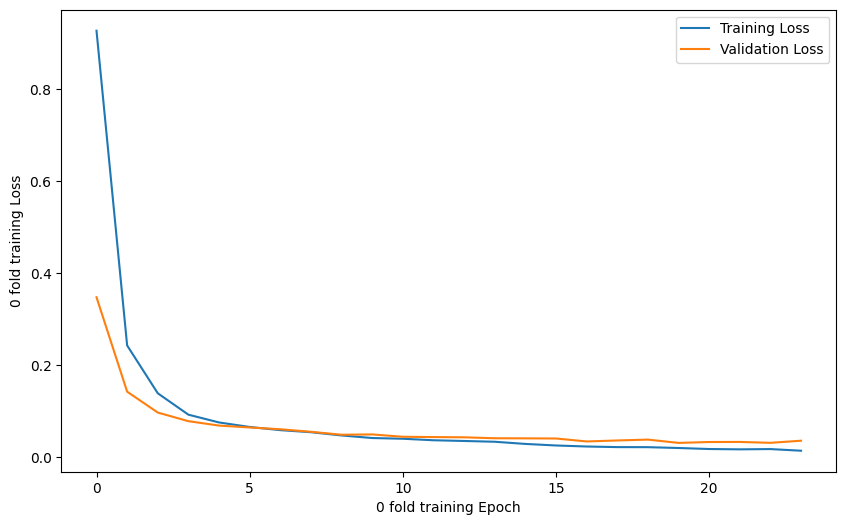

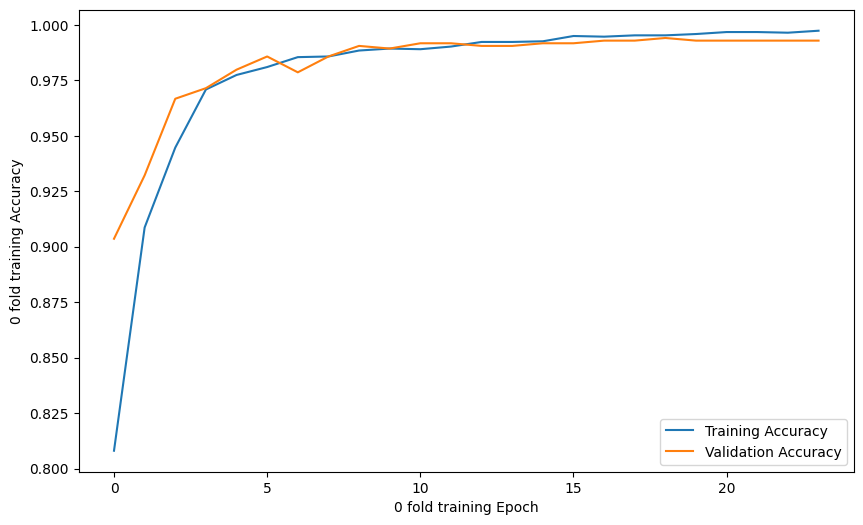

[INFO] 0 fold training training complete！（happy）
[INFO]0 fold densenet201 model storing...
[INFO]0 fold densenet201 model storing complete！
27/27 [==============================] - 11s 155ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

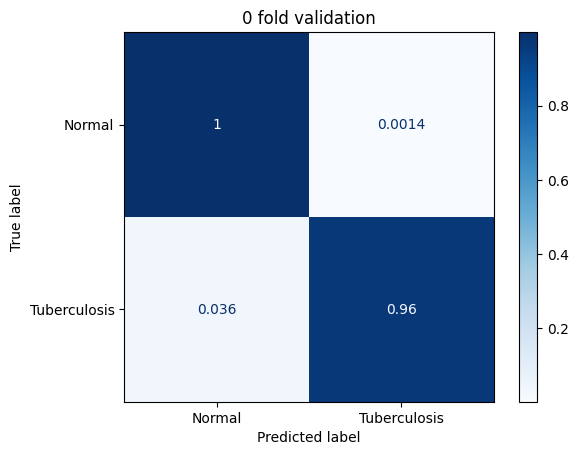

AUC: 0.997


<Figure size 640x480 with 0 Axes>

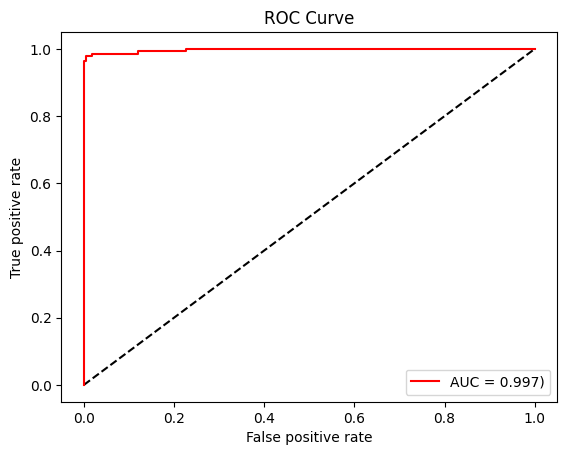

normal_wrong_indices: [115]
tuberculosis_wrong_indices: [53, 66, 103, 121, 136]
[INFO] 1 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 29s 1s/step - loss: 1.2123 - accuracy: 0.7598 - val_loss: 0.4920 - val_accuracy: 0.8726
Epoch 2/200
12/12 [==============================] - 10s 819ms/step - loss: 0.3349 - accuracy: 0.8890 - val_loss: 0.2051 - val_accuracy: 0.9131
Epoch 3/200
12/12 [==============================] - 10s 826ms/step - loss: 0.1660 - accuracy: 0.9339 - val_loss: 0.1331 - val_accuracy: 0.9595
Epoch 4/200
12/12 [==============================] - 10s 822ms/step - loss: 0.1122 - accuracy: 0.9601 - val_loss: 0.1175 - val_accuracy: 0.9631
Epoch 5/200
12/12 [==============================] - 10s 817ms/step - loss: 0.0898 - accuracy: 0.9667 - val_loss: 0.1056 - val_accuracy: 0.9679
Epoch 6/200
12/12 [==============================] - 10s 829ms/step - loss: 0.0732 - accuracy: 0.9747 - val_loss: 0.0920 - val_accuracy: 0.9702
Epoch 7/20

<Figure size 640x480 with 0 Axes>

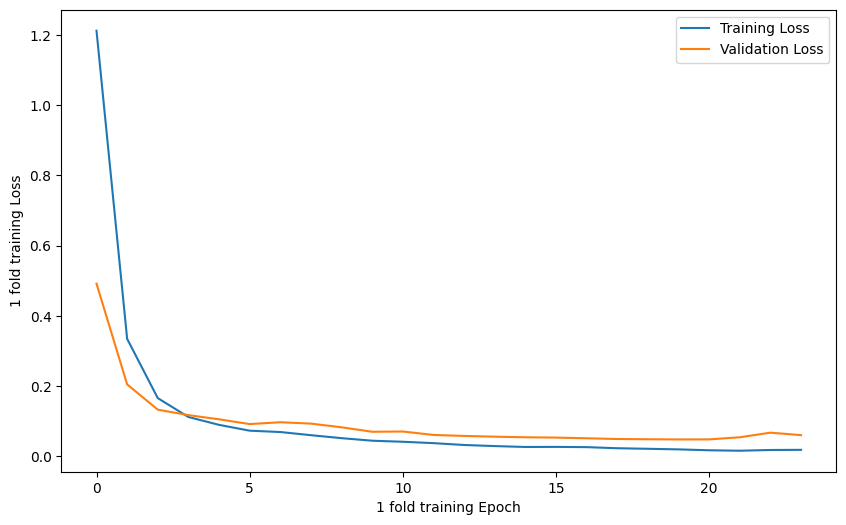

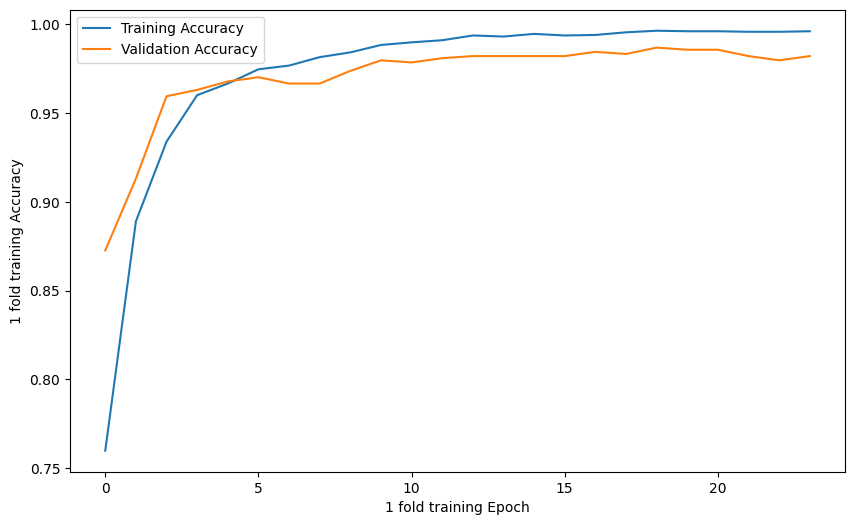

[INFO] 1 fold training training complete！（happy）
[INFO]1 fold densenet201 model storing...
[INFO]1 fold densenet201 model storing complete！
27/27 [==============================] - 8s 82ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

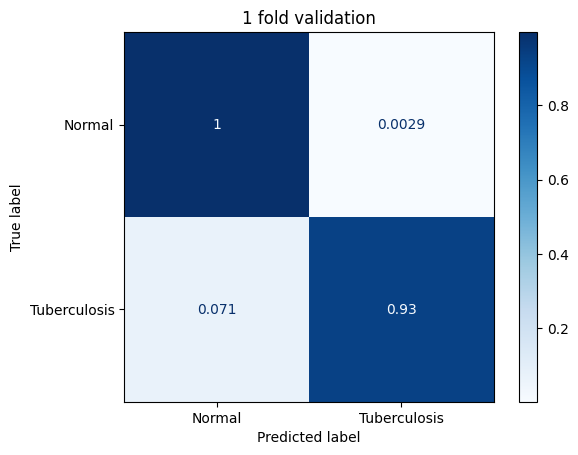

AUC: 0.995


<Figure size 640x480 with 0 Axes>

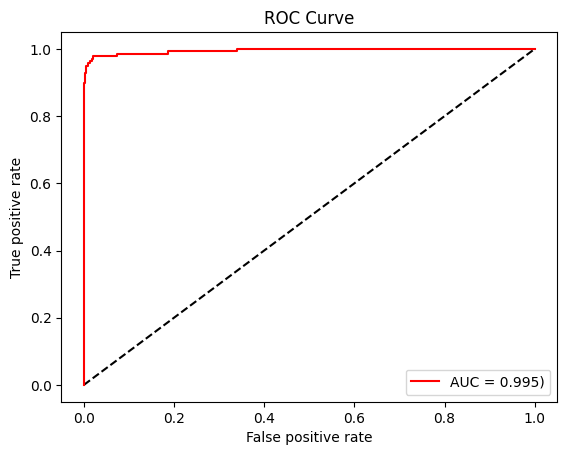

normal_wrong_indices: [159, 566]
tuberculosis_wrong_indices: [0, 3, 13, 31, 42, 57, 79, 83, 102, 116]
[INFO] 2 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 30s 1s/step - loss: 0.6446 - accuracy: 0.8390 - val_loss: 0.3899 - val_accuracy: 0.8536
Epoch 2/200
12/12 [==============================] - 10s 821ms/step - loss: 0.2163 - accuracy: 0.9196 - val_loss: 0.1141 - val_accuracy: 0.9571
Epoch 3/200
12/12 [==============================] - 10s 824ms/step - loss: 0.1122 - accuracy: 0.9568 - val_loss: 0.0804 - val_accuracy: 0.9738
Epoch 4/200
12/12 [==============================] - 10s 822ms/step - loss: 0.0802 - accuracy: 0.9759 - val_loss: 0.0617 - val_accuracy: 0.9821
Epoch 5/200
12/12 [==============================] - 10s 815ms/step - loss: 0.0654 - accuracy: 0.9812 - val_loss: 0.0562 - val_accuracy: 0.9810
Epoch 6/200
12/12 [==============================] - 10s 818ms/step - loss: 0.0567 - accuracy: 0.9824 - val_loss: 0.0429 - val_accur

<Figure size 640x480 with 0 Axes>

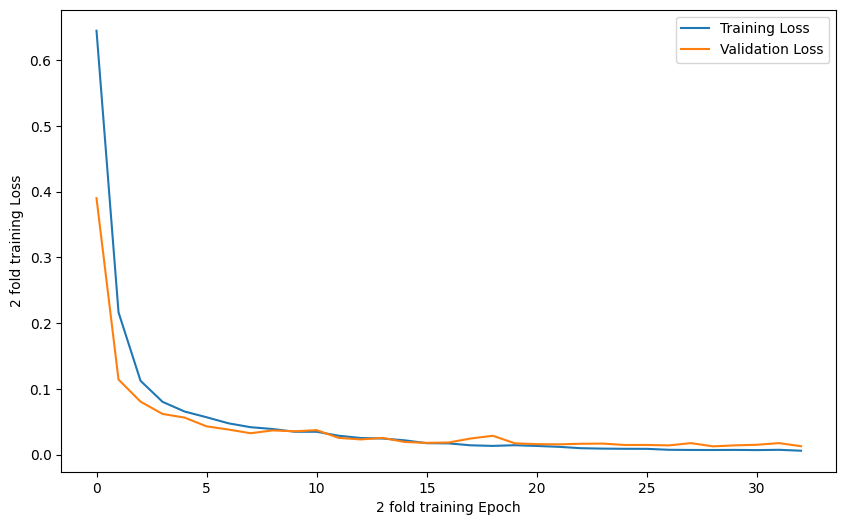

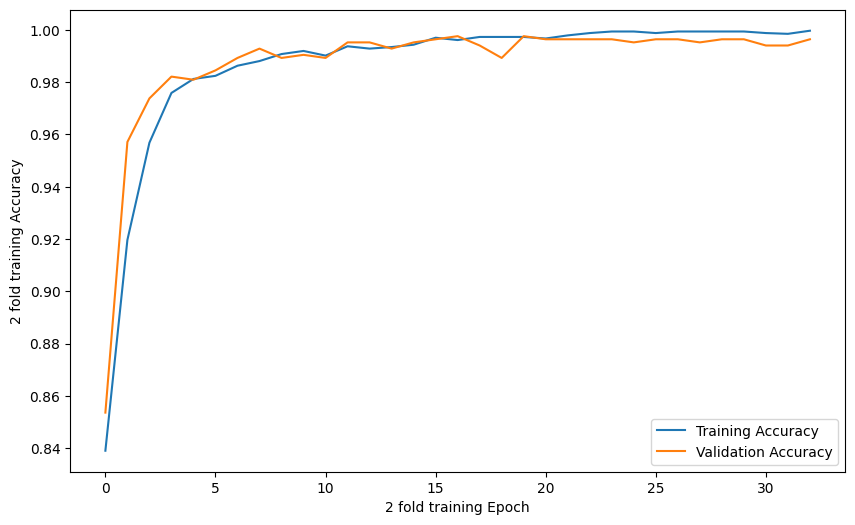

[INFO] 2 fold training training complete！（happy）
[INFO]2 fold densenet201 model storing...
[INFO]2 fold densenet201 model storing complete！
27/27 [==============================] - 6s 80ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

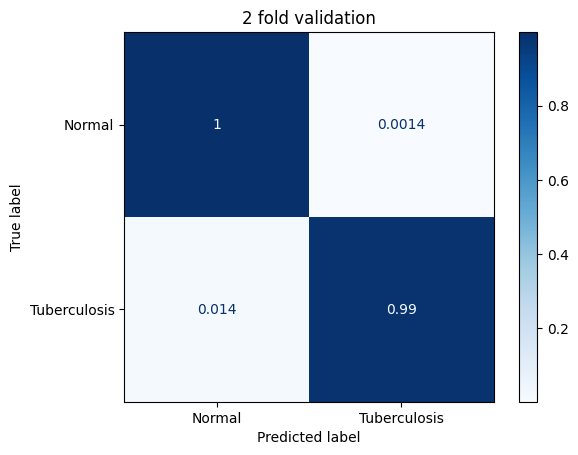

AUC: 1.000


<Figure size 640x480 with 0 Axes>

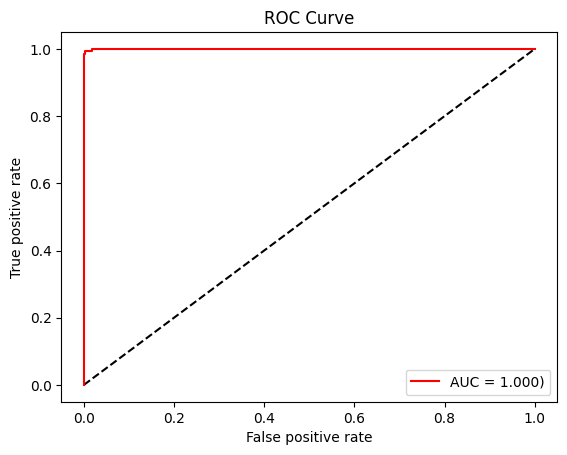

normal_wrong_indices: [487]
tuberculosis_wrong_indices: [59, 88]
[INFO] 3 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 29s 1s/step - loss: 0.6760 - accuracy: 0.8000 - val_loss: 0.3152 - val_accuracy: 0.8869
Epoch 2/200
12/12 [==============================] - 10s 826ms/step - loss: 0.2257 - accuracy: 0.9131 - val_loss: 0.1506 - val_accuracy: 0.9429
Epoch 3/200
12/12 [==============================] - 10s 821ms/step - loss: 0.1167 - accuracy: 0.9580 - val_loss: 0.1006 - val_accuracy: 0.9679
Epoch 4/200
12/12 [==============================] - 10s 818ms/step - loss: 0.0852 - accuracy: 0.9699 - val_loss: 0.0847 - val_accuracy: 0.9702
Epoch 5/200
12/12 [==============================] - 10s 822ms/step - loss: 0.0681 - accuracy: 0.9810 - val_loss: 0.0750 - val_accuracy: 0.9762
Epoch 6/200
12/12 [==============================] - 10s 824ms/step - loss: 0.0587 - accuracy: 0.9836 - val_loss: 0.0675 - val_accuracy: 0.9845
Epoch 7/200
12/12 [======

<Figure size 640x480 with 0 Axes>

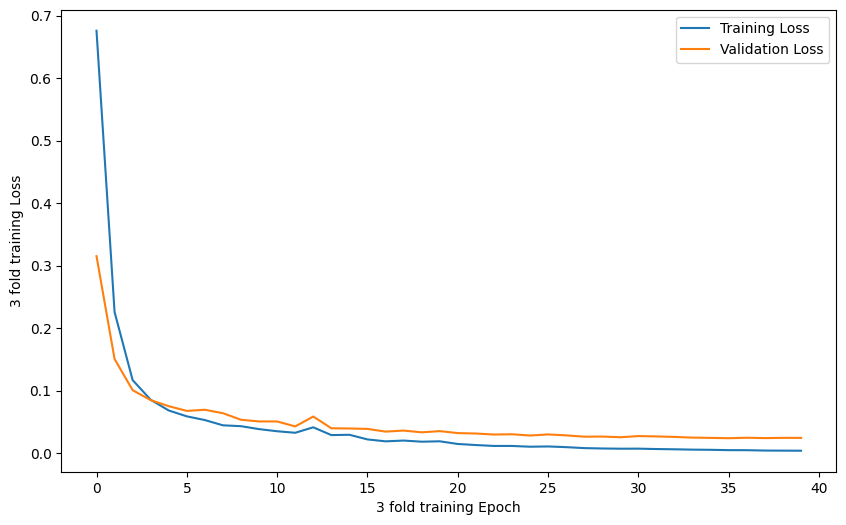

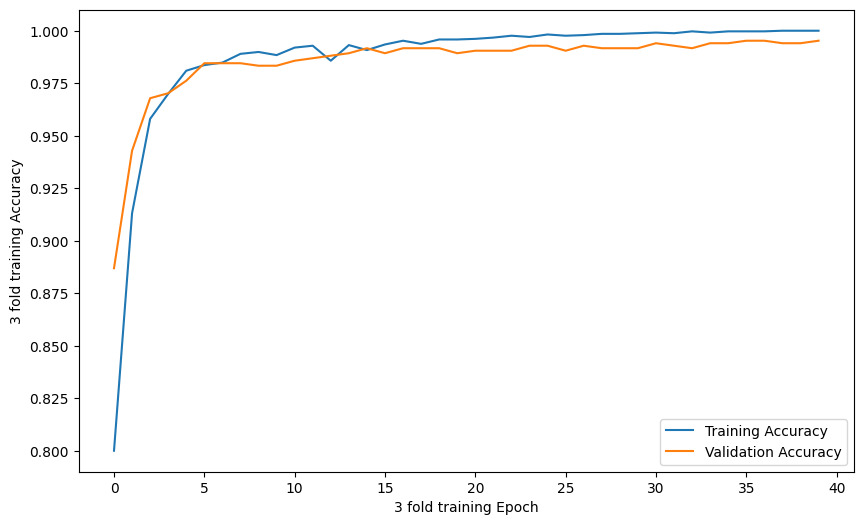

[INFO] 3 fold training training complete！（happy）
[INFO]3 fold densenet201 model storing...
[INFO]3 fold densenet201 model storing complete！
27/27 [==============================] - 7s 79ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

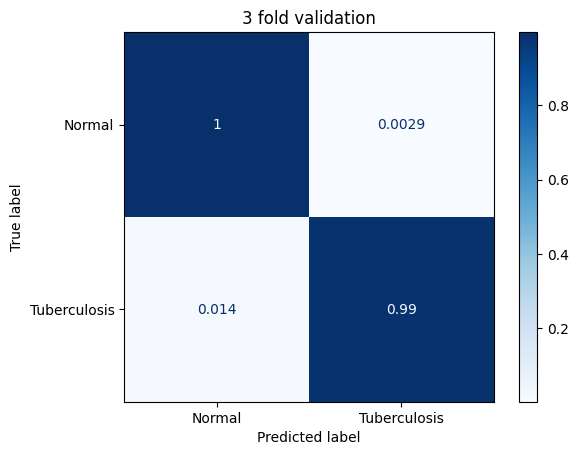

AUC: 0.995


<Figure size 640x480 with 0 Axes>

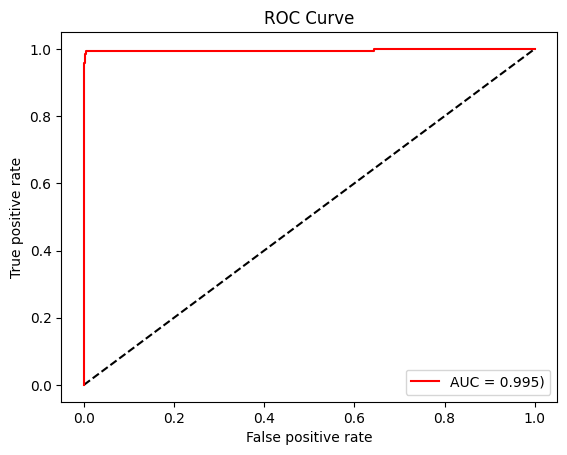

normal_wrong_indices: [311, 495]
tuberculosis_wrong_indices: [5, 112]
[INFO] 4 fold training strating training！（happy）
Epoch 1/200
12/12 [==============================] - 30s 1s/step - loss: 1.5216 - accuracy: 0.7060 - val_loss: 0.4899 - val_accuracy: 0.8774
Epoch 2/200
12/12 [==============================] - 10s 822ms/step - loss: 0.3979 - accuracy: 0.8932 - val_loss: 0.1696 - val_accuracy: 0.9250
Epoch 3/200
12/12 [==============================] - 9s 751ms/step - loss: 0.1901 - accuracy: 0.9289 - val_loss: 0.1963 - val_accuracy: 0.9298
Epoch 4/200
12/12 [==============================] - 10s 818ms/step - loss: 0.1326 - accuracy: 0.9482 - val_loss: 0.1365 - val_accuracy: 0.9524
Epoch 5/200
12/12 [==============================] - 10s 826ms/step - loss: 0.1081 - accuracy: 0.9610 - val_loss: 0.1024 - val_accuracy: 0.9667
Epoch 6/200
12/12 [==============================] - 10s 824ms/step - loss: 0.0884 - accuracy: 0.9717 - val_loss: 0.0876 - val_accuracy: 0.9679
Epoch 7/200
12/12 [==

<Figure size 640x480 with 0 Axes>

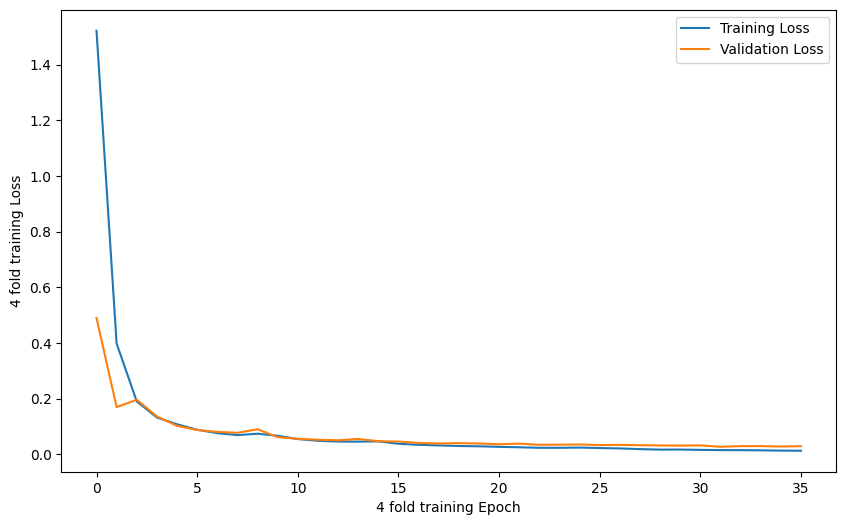

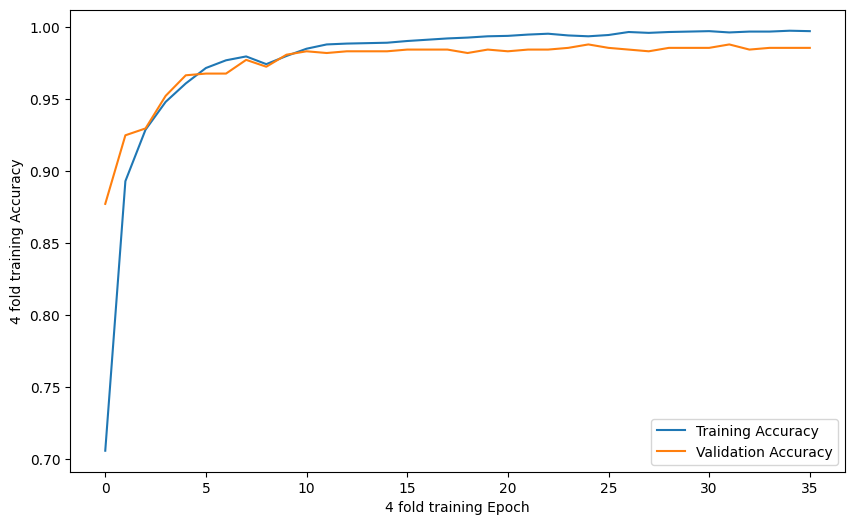

[INFO] 4 fold training training complete！（happy）
[INFO]4 fold densenet201 model storing...
[INFO]4 fold densenet201 model storing complete！
27/27 [==============================] - 6s 78ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

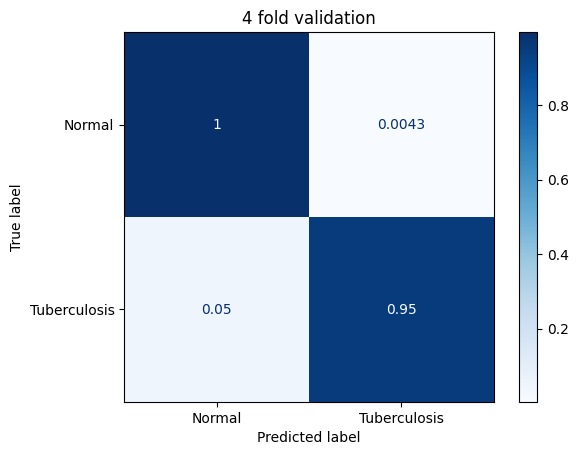

AUC: 1.000


<Figure size 640x480 with 0 Axes>

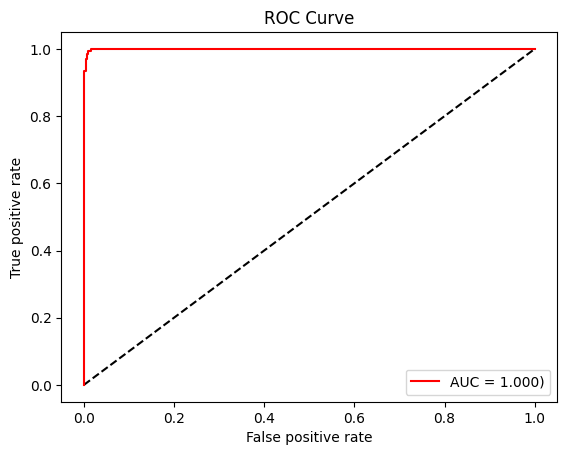

normal_wrong_indices: [76, 341, 556]
tuberculosis_wrong_indices: [57, 62, 71, 78, 85, 106, 107]
                            0_fold      1_fold      2_fold      3_fold  \
0_precision               0.992898    0.985876    0.997147    0.997143   
0_recall                  0.998571    0.997143    0.998571    0.997143   
0_f1-score                0.995726    0.991477    0.997859    0.997143   
0_support               700.000000  700.000000  700.000000  700.000000   
1_precision               0.992647    0.984848    0.992806    0.985714   
1_recall                  0.964286    0.928571    0.985714    0.985714   
1_f1-score                0.978261    0.955882    0.989247    0.985714   
1_support               140.000000  140.000000  140.000000  140.000000   
accuracy                  0.992857    0.985714    0.996429    0.995238   
macro avg_precision       0.992772    0.985362    0.994976    0.991429   
macro avg_recall          0.981429    0.962857    0.992143    0.991429   
macro avg_f1-sco

<Figure size 640x480 with 0 Axes>

In [107]:
from tensorflow import test
if test.is_gpu_available():
    cross_validation(data, labels, nfolds=5, patience=4,random_state = args["SEED"],model_type=args["MODEL_TYPE"])
else:
    print("no GPU, you'd better not run it")

In [108]:
# #test
# import tensorflow as tf
# import keras_cv
# import numpy as np
# import keras.applications
# from keras.models import load_model
# from keras_cv.models import DenseNetBackbone 
# from tensorflow.keras import Input, regularizers
# from tensorflow.keras import Model
# from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Activation
# from keras.applications import DenseNet201

# #from keras import load_weights
# print(dir(keras.models))
# print(dir(keras.applications))

# inputs = Input(shape=(args["NEW_WIDTH"], args["NEW_HEIGHT"], 3))

# # Pretrained backbone
# #model = keras_cv.models.DenseNetBackbone.from_preset("densenet201_imagenet")
# # output = model(input_data)
# # Randomly initialized backbone with a custom config
# model = DenseNet201(weights=None)

# # model.summary()
# # for layer in model.layers:  
# #     print(layer.name, layer.trainable)
    
# model.load_weights("../input/densenet201/model.weights.h5") 
# #, custom_objects={'my_custom_layer': MyCustomLayer})


# x = model(inputs, training=False) 
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.8)(x)
# x = Dense(128, kernel_regularizer=regularizers.l2(0.1))(x)  
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# outputs = Dense(1, kernel_regularizer=regularizers.l2(0.1))(x) 
# outputs = BatchNormalization()(outputs)
# outputs = Activation('sigmoid')(outputs)
# model = Model(inputs, outputs)

# model.summary()
# for layer in model.layers:  
#     print(layer.name, layer.trainable)

In [109]:
# from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model

# # load the pretrianed DenseNet201 model
# base_model = DenseNet201(weights='/kaggle/input/densenetbackbone/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', 
#                     include_top=False, input_shape=(args["NEW_WIDTH"], args["NEW_HEIGHT"], 3))

# #freeze the backbone layer
# for layer in base_model.layers:
#     layer.trainable = False

# # add the classifier to DenseNet
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)  
# predictions = Dense(1, activation='sigmoid')(x)  

# # construct the whole model
# model = Model(inputs=base_model.input, outputs=predictions)

# model.summary()

In [110]:
# #数据集切分
# (trainX,testX,trainY,testY) = train_test_split(
#                         data,labels,
#                         test_size=0.1,
#                         random_state=args["SEED"],stratify = labels) #test.size=0.1可调整

In [111]:
# print(trainX.shape,testX.shape,
#       trainY.shape,testY.shape)
# print(np.mean(trainY==0),np.mean(testY==0))

In [112]:
# ## build and train the model
# import tensorflow as tf 
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"]) #使用双GPU或者单GPU , , "/gpu:1"
# with strategy.scope(): 
#     model = create_model(args["MODEL_TYPE"])
#     train_model(model,trainX,testX,trainY,testY)


In [113]:
# #储存模型
# print("[INFO] 正在储存模型")
# model.save('chest_xray_model.keras')
# print("[INFO] 储存模型完成！")

In [114]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink,FileLinks
for i in os.listdir("/kaggle/working"):
    print(i)
    try:
        FileLink(i)
    except:
        FileLinks(i)

/kaggle/working
['.virtual_documents', '3_fold_densenet201_chest_xray_model.keras', '0_fold_densenet201_chest_xray_model.keras', '4 fold validationROC_plot.png', '2 fold validationconfusion_matrix.png', '3 fold validationROC_plot.png', '0 fold validationconfusion_matrix.png', '1 fold validationROC_plot.png', '2 fold validationROC_plot.png', '3 fold validationconfusion_matrix.png', '1 fold validationconfusion_matrix.png', '2_fold_densenet201_chest_xray_model.keras', '4 fold validationconfusion_matrix.png', 'cross_validation_reports.csv', '1_fold_densenet201_chest_xray_model.keras', '4_fold_densenet201_chest_xray_model.keras', '0 fold validationROC_plot.png']
.virtual_documents
3_fold_densenet201_chest_xray_model.keras
0_fold_densenet201_chest_xray_model.keras
4 fold validationROC_plot.png
2 fold validationconfusion_matrix.png
3 fold validationROC_plot.png
0 fold validationconfusion_matrix.png
1 fold validationROC_plot.png
2 fold validationROC_plot.png
3 fold validationconfusion_matrix.p

In [128]:
FileLink(f'0_fold_{args["MODEL_TYPE"]}_chest_xray_model.keras')

/kaggle/working/0_fold_densenet201_chest_xray_model.keras

In [129]:
FileLink(f'1_fold_{args["MODEL_TYPE"]}_chest_xray_model.keras')

/kaggle/working/1_fold_densenet201_chest_xray_model.keras

In [130]:
FileLink(f'2_fold_{args["MODEL_TYPE"]}_chest_xray_model.keras')

/kaggle/working/2_fold_densenet201_chest_xray_model.keras

In [131]:
FileLink(f'3_fold_{args["MODEL_TYPE"]}_chest_xray_model.keras')

/kaggle/working/3_fold_densenet201_chest_xray_model.keras

In [132]:
FileLink(f'4_fold_{args["MODEL_TYPE"]}_chest_xray_model.keras')

/kaggle/working/4_fold_densenet201_chest_xray_model.keras

In [120]:
# predict_model(testX, testY)

In [121]:
# from keras.models import load_model
# model = load_model('chest_xray_model.keras')

In [122]:
# test_data,test_labels= input_images_preprocess(
#     data_dir= '../input/old-data-split/testing',#args["test_dataset"],
#     target_classes = ["Normal","Tuberculosis"]#test_classes
# )
# print("[INFO] 测试finetune前的外部数据test_set")
# predict_model(test_data, test_labels)

# test_data,test_labels= input_images_preprocess(
#     data_dir='../input/chest-xray-pneumoniacovid19tuberculosis/test', #args["test_dataset"],
#     target_classes =['NORMAL','TURBERCULOSIS'] #test_classes
# )
# print("[INFO] 测试finetune前的外部数据test_set")
# predict_model(test_data, test_labels)

In [123]:
# import cv2
# import os
# import numpy as np
# from keras.models import load_model
# from keras.utils import to_categorical
# from sklearn.preprocessing import LabelBinarizer

In [124]:
# finetune_data,finetune_labels= input_images_preprocess(
#     data_dir=args["finetune_dataset"],
#     target_classes = finetune_classes)

In [125]:
# #数据集切分
# (finetune_trainX,finetune_testX,finetune_trainY,finetune_testY) = train_test_split(
#                         finetune_data,finetune_labels,
#                         test_size=0.1,
#                         random_state=args["SEED"],stratify = finetune_labels) #test.size=0.1可调整

In [126]:
# #finetune
# import tensorflow as tf 
# # with tf.device('/gpu:0'): #使用GPU
# #     model = Sequential()
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"]) #使用双GPU或者单GPU , , "/gpu:1"
# with strategy.scope():
    
#     # Load the pre-trained model
#     model = load_model('chest_xray_model.keras')  # Replace with your actual model file
    
#     print("[INFO] 准备finetune网络罢！（喜）")
#     train_model(model,finetune_trainX,finetune_testX,finetune_trainY,finetune_testY,
#                 present="finetune",patience=10)
#     print("[INFO] finetune结束啦！（喜）")
    

In [127]:
# print("[INFO] 测试finetune后的外部数据test_set")
# predict_model(test_data, test_labels)